In [17]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from os import listdir
from os.path import isfile, join
import json
onlyfiles = [f for f in listdir("./csvFolder") if isfile(join("./csvFolder", f))]


print(len(onlyfiles))
onlyfiles[:5]


600


In [10]:
def parse_file_name(file_name):
    pattern = r'csv-(\d{4}-\d{2}-\d{2})-(\d{2}-\d{2}-\d{2})-(\w+)-(\d+)-iPhone\d+-(\d+)-(\d+\.\d+)-(\d+\.\d+)-(\d+\.\d+)-(\d{2}-\d{2}-\d+\.\d+)\.csv'
    match = re.match(pattern, file_name)
    if match:
        return {
            'date': match.group(1),
            'time': match.group(2),
            'event_type': match.group(3),
            'version': int(match.group(4)),
            'snore_count': int(match.group(5)),
            'avg_db': float(match.group(6)),
            'max_db': float(match.group(7)),
            # 'start_db': float(match.group(8)),
            'start_snore_event_timestamp': match.group(9)
        }
    else:
        raise Exception('Not possible')

parsed_data = [parse_file_name(fn) for fn in onlyfiles if parse_file_name(fn) is not None]

df = pd.DataFrame(parsed_data)
df['datetime'] = df.apply(lambda row: datetime.strptime(f"{row['date']} {row['time']}", '%Y-%m-%d %H-%M-%S'), axis=1)
df = df.drop(['date', 'time'], axis=1)

df = df.sort_values(by='datetime')

df_hour = df.copy()

df_hour['hour'] = df['datetime'].dt.hour


df.reset_index(inplace=True)
df = df.drop(columns=['index'])
# df.head()
df.describe()
# df_15 = df.loc[0:14]


# df_15


,version,snore_count,avg_db,max_db,datetime
count,600.0,600.000000,600.000000,600.000000,600
mean,1035.0,4.036667,43.970733,45.147550,2023-12-15 11:53:46.000000256
min,1035.0,0.000000,0.320000,0.020000,2023-12-15 06:54:16
25%,1035.0,0.000000,21.250000,23.782500,2023-12-15 09:24:01
50%,1035.0,1.000000,43.060000,44.055000,2023-12-15 11:53:46
75%,1035.0,8.000000,66.365000,67.805000,2023-12-15 14:23:31
max,1035.0,15.000000,89.810000,89.970000,2023-12-15 16:53:16
std,0.0,5.041927,26.087752,25.493249,NaN


In [11]:
df.head(15)

,event_type,version,snore_count,avg_db,max_db,start_snore_event_timestamp,datetime
0,none,1035,0,9.63,86.63,06-54-41.312,2023-12-15 06:54:16
1,snore,1035,5,12.05,86.56,06-55-50.280,2023-12-15 06:55:16
2,snore,1035,8,10.33,13.23,06-56-55.141,2023-12-15 06:56:16
3,snore,1035,6,38.36,71.41,06-57-56.482,2023-12-15 06:57:16
4,snore,1035,11,1.45,33.78,06-58-10.229,2023-12-15 06:58:16
5,snore,1035,5,6.76,39.25,06-59-23.614,2023-12-15 06:59:16
6,snore,1035,11,76.71,2.97,07-00-15.629,2023-12-15 07:00:16
7,snore,1035,9,9.30,7.16,07-01-30.392,2023-12-15 07:01:16
8,none,1035,0,58.96,4.39,07-02-50.597,2023-12-15 07:02:16
9,none,1035,0,48.21,10.72,07-03-15.546,2023-12-15 07:03:16


In [12]:
df['datetime'] = pd.to_datetime(df['datetime'])

aggregated_data = df.resample('15T', on='datetime').agg({
    'avg_db': 'mean',
    'snore_count': 'sum',
    'max_db': 'max',
    'event_type': 'first',
})

aggregated_data.reset_index(inplace=True)

aggregated_data


,datetime,avg_db,snore_count,max_db,event_type
0,2023-12-15 06:45:00,13.096667,35,86.63,none
1,2023-12-15 07:00:00,33.946667,44,80.79,snore
2,2023-12-15 07:15:00,47.883333,30,77.62,none
3,2023-12-15 07:30:00,55.586000,65,68.52,none
4,2023-12-15 07:45:00,53.983333,44,86.58,none
5,2023-12-15 08:00:00,45.506000,67,86.44,snore
6,2023-12-15 08:15:00,44.162000,47,84.41,none
7,2023-12-15 08:30:00,51.410000,64,83.65,none
8,2023-12-15 08:45:00,50.089333,79,85.61,none
9,2023-12-15 09:00:00,35.925333,15,89.97,none


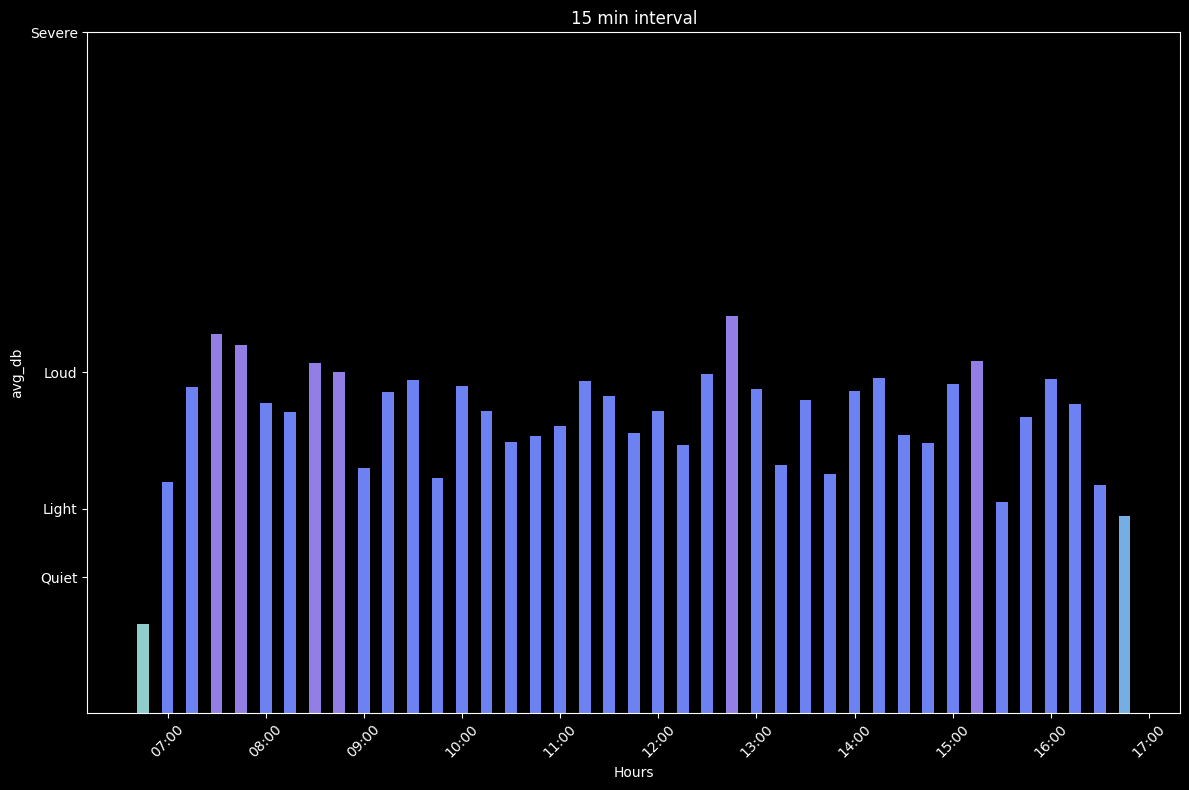

In [13]:
import matplotlib.dates as mdates



db_ranges = {
    'Quiet': (0, 20),
    'Light': (20, 30),
    'Loud': (30, 50),
    'Severe': (50, 100)
}

def get_color(db_value):
    for level, (low, high) in db_ranges.items():
        if low <= db_value < high:
            return level
    return 'Quiet'

aggregated_data['color_level'] = aggregated_data['avg_db'].apply(get_color)

color_map = {
    'Quiet': '#8fcccc',
    'Light': '#73aee5',
    'Loud': '#6d82f2',
    'Severe': '#937ee5'
}

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.005

colors = aggregated_data['color_level'].map(color_map)
ax.bar(aggregated_data['datetime'], aggregated_data['avg_db'], width=bar_width, color=colors, align='center')


ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

ax.set_xlabel('Hours')
ax.set_ylabel('avg_db')
ax.set_title('15 min interval')

ax.set_yticks([20, 30, 50, 100])
ax.set_yticklabels(['Quiet', 'Light', 'Loud', 'Severe'])

plt.tight_layout()

plt.show()

In [14]:

api_json_object = json.loads(aggregated_data.to_json(orient='records', date_format='iso'))


with open("dump_graph.json", 'w') as f:
    json.dump(api_json_object, f, indent=4)

f.close()



api_json_object[:5]


[{'datetime': '2023-12-15T06:45:00.000',
  'avg_db': 13.0966666667,
  'snore_count': 35,
  'max_db': 86.63,
  'event_type': 'none',
  'color_level': 'Quiet'},
 {'datetime': '2023-12-15T07:00:00.000',
  'avg_db': 33.9466666667,
  'snore_count': 44,
  'max_db': 80.79,
  'event_type': 'snore',
  'color_level': 'Loud'},
 {'datetime': '2023-12-15T07:15:00.000',
  'avg_db': 47.8833333333,
  'snore_count': 30,
  'max_db': 77.62,
  'event_type': 'none',
  'color_level': 'Loud'},
 {'datetime': '2023-12-15T07:30:00.000',
  'avg_db': 55.586,
  'snore_count': 65,
  'max_db': 68.52,
  'event_type': 'none',
  'color_level': 'Severe'},
 {'datetime': '2023-12-15T07:45:00.000',
  'avg_db': 53.9833333333,
  'snore_count': 44,
  'max_db': 86.58,
  'event_type': 'none',
  'color_level': 'Severe'}]